In [177]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# Load training dataset and testing dataset
df = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [191]:
# Data visualization, thanks Abdul for sharing the visualization code
def plot_char(df):  
    word_end_indices = list(df[df.NextId == -1].index)
    begin = 0
    wordset = set([])
    words = []
    word_images = []
    for wend in word_end_indices:
        word = ''.join(df['Prediction'][begin:wend+1])
        if word not in wordset:
            wordset.add(word)
            word_images.append(df.iloc[begin:wend+1,4:].as_matrix())
            words.append(word)
        begin = wend+1
    word_images = np.array(word_images)

    num_words = 10
    max_len = max(map(len, words))
    fig, axes_arr = plt.subplots(num_words, max_len, figsize=(15,16))
    for i, w in enumerate(word_images[:num_words]):
        w = w.reshape(-1, 16, 8)
        for j, letter in enumerate(w):
            axes_arr[i,j].imshow(letter)
            axes_arr[i,j].set_title(words[i][j])
            axes_arr[i,j].axis('off')
        for k in range(j,max_len):
            axes_arr[i,k].axis('off')

    plt.show()

In [192]:
# Function to get the unique word list from dataset
def word_list(df):
    word_end_indices = list(df[df.NextId == -1].index)
    words = []
    begin =0
    for wend in word_end_indices:
        word = ''.join(df['Prediction'][begin:wend+1])
        begin = wend + 1
        words.append(word)
    
    words = set(words)
    return list(words)

In [190]:
# Understanding the data first
# Show column list of dataset
df.columns

Index(['Id', 'Prediction', 'NextId', 'Position', 'p_0_0', 'p_0_1', 'p_0_2',
       'p_0_3', 'p_0_4', 'p_0_5',
       ...
       'p_14_6', 'p_14_7', 'p_15_0', 'p_15_1', 'p_15_2', 'p_15_3', 'p_15_4',
       'p_15_5', 'p_15_6', 'p_15_7'],
      dtype='object', length=132)

In [193]:
# word list in training set
word_list(df)

['axi',
 'uzz',
 'abulously',
 'ejuvenating',
 'eclaring',
 'evving',
 'earbook',
 'mitted',
 'nconsequential',
 'poiling',
 'omparatively',
 'ransform',
 'olcanic',
 'afeteria',
 'isqualified',
 'mbraces',
 'ccountability',
 'uzzlement',
 'ero',
 'obble',
 'enu',
 'hadow',
 'anquish',
 'ncomfortably',
 'ump',
 'ake',
 'ugging',
 'ormalization',
 'rojections',
 'ndustrialized',
 'ylophone',
 'eeker',
 'uizzically',
 'ommanding',
 'eography',
 'cknowledgement',
 'ate',
 'idding',
 'acking',
 'gonizingly',
 'kiing',
 'nworkable',
 'nnouncing',
 'uff',
 'ecompress',
 'ustifications',
 'urrounded',
 'nvulnerable',
 'pproaching',
 'rightfully',
 'ympathetically',
 'nexpected',
 'wab',
 'omplex',
 'overning']

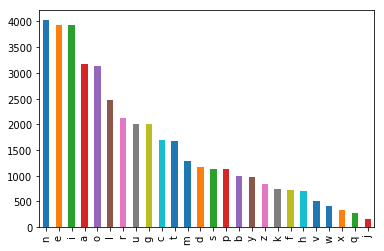

In [194]:
# look at the frequency of each character appears in the trainning set
prediction_value_counts = df['Prediction'].value_counts()
prediction_value_counts.plot(kind='bar')

In [201]:
# To see the correlation between prediction and position
df['Pred_ORD'] = df['Prediction'].apply(lambda x: ord(x))
df['Pred_ORD'].corr(df['Position'])

-0.012500107677328122

In [202]:
df = df.drop(['Pred_ORD'], axis = 1)

In [2]:
# Preprocessing function
# 1. Get the pixel array with size of 128 of next character, denoted as y_next
# 2. Get the pixel array with size of 128 of previous character, denoted as y_prev
# 3. Get position array with size of 16, denoted as p
# 4. Convert Prediction character into an array with size of 26, denoted as y

def preprocessing(df):
    
    y = np.zeros((df.shape[0], 26))
    y_next = np.zeros((df.shape[0], 128))
    y_prev = np.zeros((df.shape[0], 128))
    p = np.zeros((df.shape[0], 16))

    for i in range(df.shape[0]):
        y_tmp = np.zeros((1, 26))
        p_tmp = np.zeros((1, 16))
        y_tmp[0, ord(df.iloc[i, 1])-97] = 1
        p_tmp[0, df.iloc[i, 3]] = 1
        y[i, :] = y_tmp
        p[i, :] = p_tmp
        if df.iloc[i, 2] != -1:
            y_next[i, :] = df.iloc[i+1, 4:]
        
        if i > 0 and df.iloc[i-1, 2] != -1:
            y_prev[i, :] = df.iloc[i-1, 4:]
        
    return y, y_next, y_prev, p

In [3]:
# Preprocess for trainning dataset
y, y_next, y_prev, p = preprocessing(df)

In [4]:
# Preprocess for testing dataset
y_t, y_t_next, y_t_prev, p_t = preprocessing(df_test)

In [5]:
# Preprocessing step 2
# Concatenate previous image data and next image data into current one
# Concatenate metadata of position info into the final set

# Therefore, the final training data set contains information about 
# pixels of current character, pixels of next character, pixels of previous character and position

def preprocessing_2(X, p, y_next, y_prev):
    #X = X.drop(columns =['Id','Prediction', 'NextId', 'Position'])
    X = X.drop(['Id','Prediction', 'NextId', 'Position'], axis = 1)
    X = X.values
    X = np.concatenate((y_prev,X), axis = 1)
    X = np.concatenate((X, y_next), axis = 1)
    X = np.concatenate((X, p), axis = 1)
    X = X.reshape(X.shape[0], 50, 8, 1)
    X = X.astype('float32')
    return X

In [6]:
# Split training set into 2 sets for training and validation, split ratio = 0.2 
X_train, X_test, y_train, y_test, p_train, p_test, y_next_train, y_next_test, y_prev_train, y_prev_test = train_test_split(df, y, p, y_next, y_prev, test_size=0.2)

In [7]:
# Prepare dataset for training and validation
X_train = preprocessing_2(X_train, p_train, y_next_train, y_prev_train)
X_test = preprocessing_2(X_test, p_test, y_next_test, y_prev_test)

In [9]:
# Prepare test data for prediction
final_test = preprocessing_2(df_test, p_t, y_t_next, y_t_prev)

In [17]:
# Create a CNN model for training
def loadModel():
    # Define model architecture
    model = Sequential()
    model.add(Conv2D(32, 3, 3, activation='relu', input_shape = (50, 8, 1)))
    #model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation ='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(26, activation='softmax'))
    return model

In [18]:
# Train the model
model = loadModel()
model.compile(loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])
model.fit(X_train, y_train, 
          batch_size =400, epochs=100, verbose = 2, validation_data = (X_test, y_test))
#score = model.evaluate(X_test, y_test, verbose = 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(50, 8, 1))`
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys


Train on 33254 samples, validate on 8314 samples
Epoch 1/100
 - 49s - loss: 2.1647 - acc: 0.3731 - val_loss: 1.0440 - val_acc: 0.7190
Epoch 2/100
 - 49s - loss: 1.3329 - acc: 0.5987 - val_loss: 0.6751 - val_acc: 0.8104
Epoch 3/100
 - 48s - loss: 1.0921 - acc: 0.6660 - val_loss: 0.5928 - val_acc: 0.8276
Epoch 4/100
 - 49s - loss: 0.9783 - acc: 0.6957 - val_loss: 0.4720 - val_acc: 0.8655
Epoch 5/100
 - 129s - loss: 0.8841 - acc: 0.7246 - val_loss: 0.4285 - val_acc: 0.8776
Epoch 6/100
 - 50s - loss: 0.8209 - acc: 0.7452 - val_loss: 0.3826 - val_acc: 0.8875
Epoch 7/100
 - 48s - loss: 0.7570 - acc: 0.7644 - val_loss: 0.3489 - val_acc: 0.9023
Epoch 8/100
 - 143s - loss: 0.7221 - acc: 0.7755 - val_loss: 0.3490 - val_acc: 0.8992
Epoch 9/100
 - 58s - loss: 0.6747 - acc: 0.7865 - val_loss: 0.3139 - val_acc: 0.9104
Epoch 10/100
 - 55s - loss: 0.6414 - acc: 0.8002 - val_loss: 0.2985 - val_acc: 0.9144
Epoch 11/100
 - 51s - loss: 0.6075 - acc: 0.8085 - val_loss: 0.2781 - val_acc: 0.9188
Epoch 12/100

Epoch 96/100
 - 48s - loss: 0.1012 - acc: 0.9652 - val_loss: 0.1589 - val_acc: 0.9589
Epoch 97/100
 - 49s - loss: 0.1005 - acc: 0.9657 - val_loss: 0.1683 - val_acc: 0.9602
Epoch 98/100
 - 52s - loss: 0.0964 - acc: 0.9669 - val_loss: 0.1591 - val_acc: 0.9610
Epoch 99/100
 - 49s - loss: 0.0989 - acc: 0.9654 - val_loss: 0.1748 - val_acc: 0.9584
Epoch 100/100
 - 49s - loss: 0.1011 - acc: 0.9662 - val_loss: 0.1598 - val_acc: 0.9601


In [109]:
# Predict test data with the model
y_labels = model.predict(final_test)

In [110]:
# Function to convert labels into characters
def get_labels(y_labels):
    list_result = y_labels.tolist()
    list_char = []
    for k in range(len(list_result)):
        pred_char = chr(list_result[k].index(max(list_result[k])) + 97)
        list_char.append(pred_char)
    return list_char

In [157]:
# Load test dataset again
df_t = pd.read_csv('./test.csv')
df_t['Prediction'] = get_labels(y_labels)

In [179]:
# Call word_list function to get list of words which appear in the training set
words = word_list(df)

In [173]:
import difflib

# Function to find similar word in the word list
def find_similar_word(test_word, words):
    word_list = []
    
    for word in words:
        if len(word) == len(test_word):
            word_list.append(word)
            
    matched_words = difflib.get_close_matches(test_word, word_list)
    
    if len(matched_words)>0:
        return matched_words[0]
    else:
        return test_word
    
# Define the function to correct the test word to the word in word dictionary if it is inside the dictionary
def correction(df, words):
    word_end_indices = list(df[df.NextId == -1].index)
    begin =0
    for wend in word_end_indices:
        test_word = ''.join(df['Prediction'][begin:wend+1])
        #if word not in wordset:
        #matched_words = difflib.get_close_matches(test_word, words)
        
        final_word = find_similar_word(test_word, words)
        
        for i in range(begin, wend+1):
            final_word = list(final_word)
            df.iloc[i, 1] = final_word[i - begin]
        begin = wend + 1
    return df

In [176]:

# Call the correction function 
df_t_new = correction(df_t, words)

# Save it to CSV file
df_t_new.to_csv('ZhengShuangyue-A0178479E.csv', columns = ["Prediction"])